In [100]:
import sys
sys.path.insert(0,'..')

In [101]:
import os
import re
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from transformers import AutoTokenizer

from src.model_functions import model_factory

In [102]:
output_folder = "charts"
model_type = "bertbase" # bertl4

folder = f"/share/home/lukash/pan16/{model_type}/cp_cp_init"
# experiment_name = "adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-age-seed{}.pt"
experiment_name = "adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-cp_init-weighted_loss_prot-age-seed{}.pt"
# experiment_name = "modular-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-gender_age-seed{}.pt"

# visualization params
par_idx = 0 # index of parametrizations
model_cat = "modular" # adverserial, modular
prot_attr = "age"
savefigs = True

In [103]:
diff_weights = []
with torch.no_grad():
    for seed in range(5):
        exp_name = experiment_name.format(seed)
        filepath = os.path.join(folder, exp_name)
        model = model_factory(filepath)

        for idx in range(model.n_parametrizations):
            if len(diff_weights)<idx+1:
                diff_weights.append({})

            dw = model.get_diff_weights(idx=idx)
            for k,v in dw:
                try:
                    diff_weights[idx][k].append(v)
                except KeyError:
                    diff_weights[idx][k] = [v]

diff_weights = [{k:torch.stack(v).bool() for k,v in dw.items()} for dw in diff_weights]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_rela

In [104]:
parameter_sizes = {k:v.numel() for k,v in diff_weights[0].items()}
parameter_sizes_emb = {k:v for k,v in parameter_sizes.items() if k[:9] == "embedding"}
parameter_sizes_layer = {k[16:]:v for k,v in parameter_sizes.items() if k[:15] == "encoder.layer.0"}

In [105]:
d = {}
for k,v in {**parameter_sizes_emb, **parameter_sizes_layer}.items():
    k_ = ".".join(k.split(".")[:-1])
    try:
        d[k_] += v
    except KeyError:
        d[k_] = v

parameter_sizes_sorted = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
parameter_sizes_sorted

{'embeddings.word_embeddings': 117204480,
 'intermediate.dense': 11811840,
 'output.dense': 11800320,
 'attention.self.query': 2952960,
 'attention.self.key': 2952960,
 'attention.self.value': 2952960,
 'attention.output.dense': 2952960,
 'embeddings.position_embeddings': 1966080,
 'embeddings.token_type_embeddings': 7680,
 'embeddings.LayerNorm': 7680,
 'attention.output.LayerNorm': 7680,
 'output.LayerNorm': 7680}

In [106]:
def analyse_fn(t):
    t_ = t.sum(0)
    total = t_.bool().sum()
    cnts = t_.view(-1).bincount(minlength=t.shape[0]+1) / total
    return cnts[1:].nan_to_num().tolist()

shares_dicts = [{k:analyse_fn(v) for k,v in dw.items()} for dw in diff_weights]

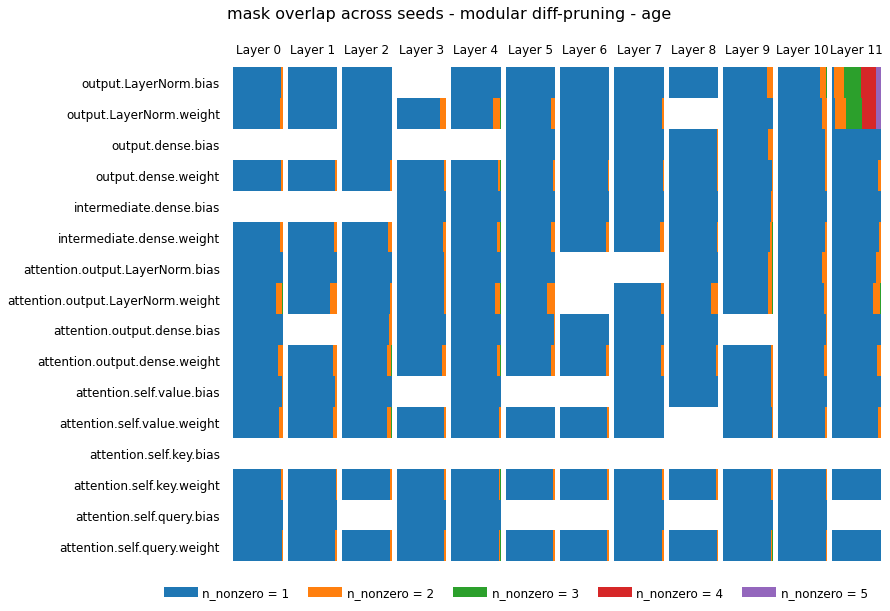

In [107]:
title = f"mask overlap across seeds - {model_cat} diff-pruning - {prot_attr}"
filename = f"mask_overlap_{model_cat}_{prot_attr}.png"

title_fontsize = 16
text_fontsize = 12
shares_dict = shares_dicts[par_idx]

shares_dict_layer_x = {k:v for k,v in shares_dict.items() if k[:14]=="encoder.layer."}
n_layers = max([int(k.split(".")[2]) for k in shares_dict_layer_x]) + 1

y_coord = np.arange(len(shares_dict_layer_x) // n_layers)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

fig, axs = plt.subplots(1, n_layers, figsize=(15, 10))
for layer_idx, ax in enumerate(axs):
    d = {".".join(k.split(".")[3:]):v for k,v in shares_dict_layer_x.items() if int(k.split(".")[2])==layer_idx}

    start = 0
    for i in range(5):
        v = np.array([x[i] for x in d.values()])
        ax.barh(y_coord, v, height=1, left=start, color=colors[i])
        start += v

    if layer_idx==0:
        ax.set_yticks(y_coord, d.keys(), fontsize=text_fontsize)
        ax.tick_params(axis="y", left=False, pad=10)
    else:
        ax.set_yticks([])
    ax.set_xticks([])
    
    ax.set_title(f"Layer {layer_idx}", fontsize=text_fontsize, y=.97)
sns.despine(left=True, bottom=True, right=True)

custom_lines = [Line2D([0], [0], color=c, lw=10) for c in colors]
plt.legend(custom_lines, [f"n_nonzero = {i}" for i in range(1,6)], ncol=5, bbox_to_anchor=(0.95, 0.02), frameon=False, fontsize=text_fontsize)

plt.suptitle(title, y=.93, fontsize=title_fontsize)
plt.subplots_adjust(left=0.3, wspace=0.1)
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()

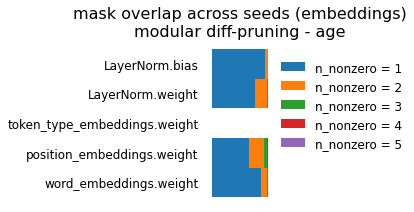

In [108]:
title = f"mask overlap across seeds (embeddings)\n{model_cat} diff-pruning - {prot_attr}"
filename = f"mask_overlap_embeddings_{model_cat}_{prot_attr}.png"

title_fontsize = 16
text_fontsize = 12
shares_dict = shares_dicts[par_idx]

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

shares_dict_layer_x = {k:v for k,v in shares_dict.items() if k[:10]=="embeddings"}
y_coord = np.arange(len(shares_dict_layer_x))
d = {".".join(k.split(".")[1:]):v for k,v in shares_dict_layer_x.items() }

plt.figure(figsize=(1, 3))
start = 0
for i in range(5):
    v = np.array([x[i] for x in d.values()])
    plt.barh(y_coord, v, height=1, left=start, color=colors[i])
    start += v

plt.yticks(y_coord, d.keys(), fontsize=text_fontsize)
plt.tick_params(axis="y", left=False, pad=10)
plt.xticks([])
    
sns.despine(left=True, bottom=True, right=True)

plt.legend([f"n_nonzero = {i}" for i in range(1,6)], bbox_to_anchor=(1.05, 0.95), fontsize=text_fontsize, frameon=False)

plt.title(title, fontsize=title_fontsize)
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()

#### Analyze tokens

In [109]:
tokenizer = AutoTokenizer.from_pretrained(model.model_name)

In [110]:
word_emb = diff_weights[0]['embeddings.word_embeddings.weight'].sum(0)
token_ids = (word_emb > 2).nonzero()[:,0].unique()
tokens = tokenizer.convert_ids_to_tokens(token_ids)
words = sorted([s for s in tokens if len(re.sub("[^\w]", "", s))>3], key=lambda x: len(x), reverse=True)

In [111]:
for word in words:
    print(word)



basketball
beautiful
looking
amazing
awesome
social
thanks
google
about
right
think
video
media
photo
gerry
stats
with
that
from
this
have
what
will
your
here
good
love
data
pack
blog
